## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-512x512'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-512x512'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))
train['anatom_enc'] = enc.fit_transform(train['anatom_site_general_challenge'].astype('str'))
test['anatom_enc'] = enc.transform(test['anatom_site_general_challenge'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# train = pd.concat([train, pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom_enc')], axis=1)
# test = pd.concat([test, pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom_enc')], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex']).target.mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex']).target.mean())
# Age
train['anatom_mean'] = train['anatom_site_general_challenge'].map(train.groupby(['anatom_site_general_challenge']).target.mean())
test['anatom_mean'] = test['anatom_site_general_challenge'].map(train.groupby(['anatom_site_general_challenge']).target.mean())

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,sex_enc,anatom_enc,sex_mean,anatom_mean
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0,1,1,0.021231,0.039892
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1,0,6,0.013766,0.022276
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2,0,2,0.013766,0.014732
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3,0,1,0.013766,0.039892
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4,0,6,0.013766,0.022276


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,anatom_enc,sex_mean,anatom_mean
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0,0.021231,0.017078
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,2,0.021231,0.014732
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,5,0.013766,0.015257
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,5,0.013766,0.015257
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,2,0.013766,0.014732


# Model

In [6]:
features = ['age_approx', 'sex_mean', 'anatom_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features
print(features)

params = {'n_estimators': 750,
          'min_child_weight': 0.81,
          'learning_rate': 0.025,
          'max_depth': 2,
          'subsample': 0.80,
          'colsample_bytree': 0.42,
          'gamma': 0.10,
          'random_state': SEED,
          'n_jobs': -1}

['age_approx', 'sex_mean', 'anatom_mean', 'sex_enc', 'anatom_enc']


# Training

In [7]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'validation' if x['tfrecord'] in idxT else 'train', axis=1)
    
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], 
              eval_metric='auc', early_stopping_rounds=10, verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Feature importance

Fold: 1


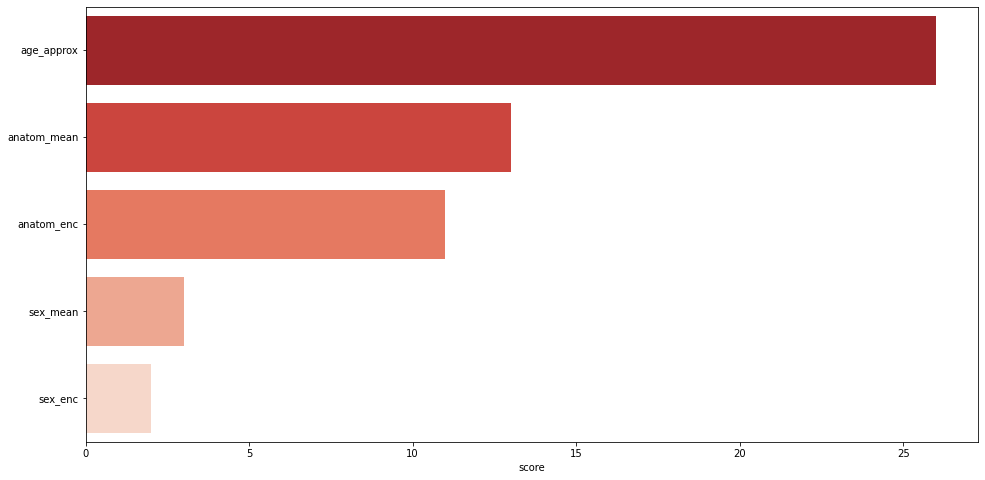

Fold: 2


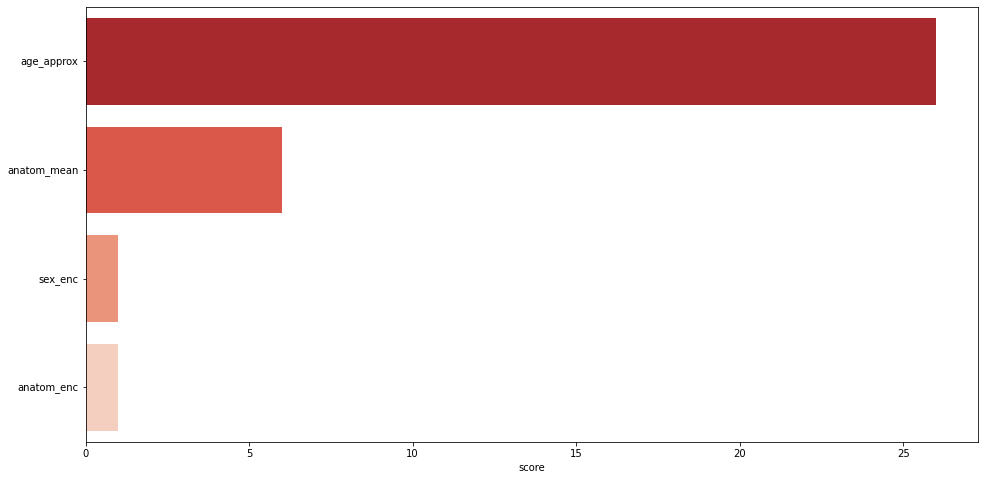

Fold: 3


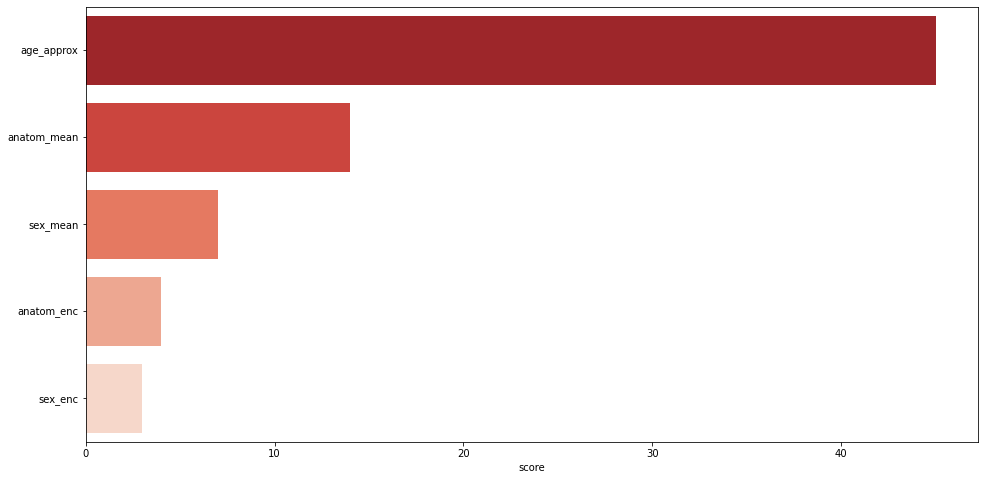

Fold: 4


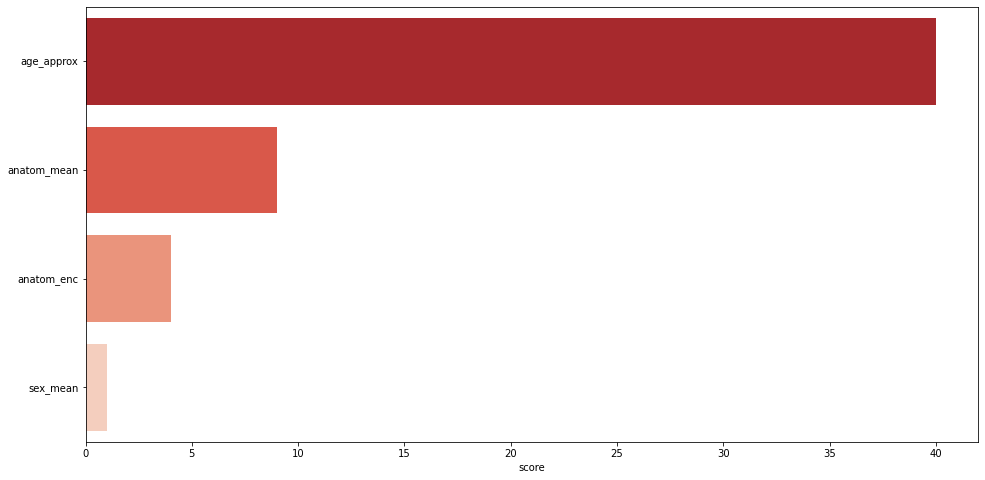

Fold: 5


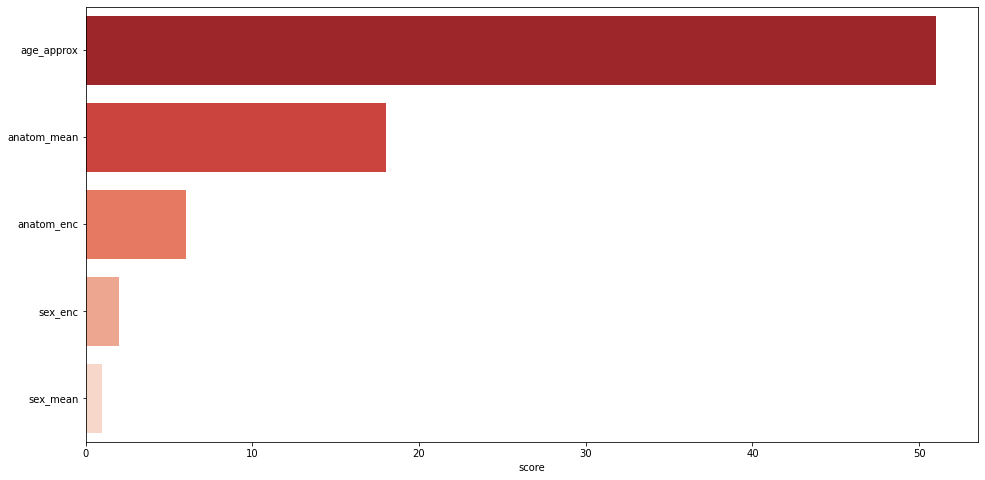

In [8]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [9]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.661438,0.669618,-0.008181,0.652812,0.657616,0.675784,0.666836,0.693242,0.666348,0.620499,0.679218,0.664851,0.678074
Accuracy,0.982904,0.982228,0.000676,0.982927,0.982222,0.982922,0.982223,0.982966,0.982211,0.982875,0.982236,0.982830,0.982247
Precision,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Support,119.200000,464.800000,-345.600000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,120.000000,464.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.661438,0.669618,-0.008181,0.652812,0.657616,0.675784,0.666836,0.693242,0.666348,0.620499,0.679218,0.664851,0.678074
male,0.661148,0.671498,-0.010350,0.655449,0.666221,0.726079,0.647290,0.638133,0.672165,0.642584,0.684252,0.643494,0.687561
female,0.635901,0.649998,-0.014097,0.647441,0.628189,0.568590,0.688011,0.696638,0.620750,0.572675,0.660915,0.694162,0.652127
head/neck,0.757936,0.745312,0.012624,0.704871,0.755033,0.847949,0.718837,0.732827,0.753928,0.770028,0.735271,0.734005,0.763490
upper extremity,0.649018,0.655967,-0.006949,0.652146,0.639330,0.676568,0.657173,0.674712,0.662552,0.597837,0.653818,0.643824,0.666961
lower extremity,0.590869,0.598545,-0.007677,0.609385,0.581021,0.568142,0.601077,0.648833,0.608406,0.532524,0.603533,0.595460,0.598689
torso,0.663472,0.662810,0.000662,0.691768,0.649488,0.690682,0.659963,0.671226,0.662662,0.628419,0.666504,0.635268,0.675432
0 <= age < 26,0.562532,0.526513,0.036019,0.580000,0.487833,0.478923,0.519063,0.869048,0.566411,0.423990,0.542175,0.460699,0.517084
26 <= age < 40,0.539682,0.515804,0.023878,0.473702,0.527091,0.572340,0.523063,0.609903,0.588422,0.469483,0.485323,0.572980,0.455119


# Adversarial Validation

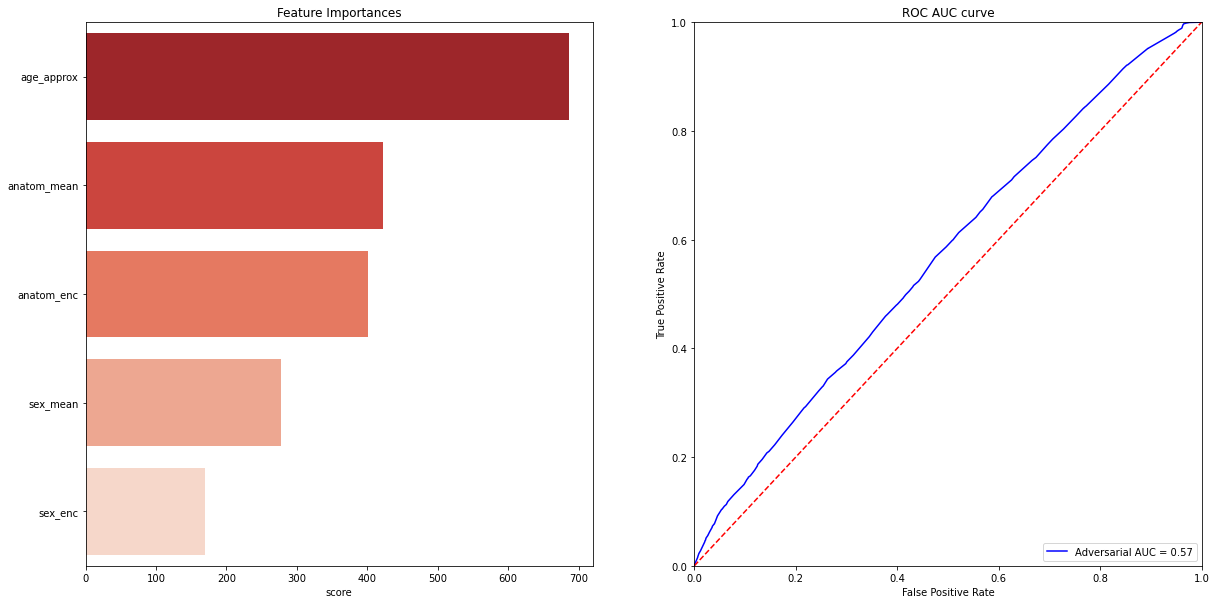

In [10]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [11]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.269129,0.283753,0.332021,0.206843,0.303723,0.219305
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.265661,0.279659,0.330884,0.201164,0.300834,0.215766
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.268161,0.283026,0.332021,0.204552,0.302895,0.218310
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.265770,0.279659,0.331200,0.201164,0.300834,0.215995
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.265569,0.279659,0.330884,0.201483,0.300552,0.215268
7,ISIC_0075663,female,35.0,torso,unknown,0,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
8,ISIC_0075914,male,30.0,torso,unknown,0,0.265569,0.279659,0.330884,0.201483,0.300552,0.215268
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.265770,0.279659,0.331200,0.201164,0.300834,0.215995
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.265661,0.279659,0.330884,0.201164,0.300834,0.215766
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.265678,0.279659,0.331200,0.201483,0.300552,0.215496
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.268599,0.281851,0.333055,0.205593,0.303070,0.219427
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.268535,0.281851,0.333055,0.205269,0.303070,0.219427
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.290564,0.319572,0.340338,0.225814,0.314690,0.252404
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.278650,0.294112,0.339188,0.214686,0.309710,0.235553
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.268599,0.281851,0.333055,0.205593,0.303070,0.219427
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.265569,0.279659,0.330884,0.201483,0.300552,0.215268


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Visualize test predictions

In [12]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.269881,0.283744,0.333055,0.206635,0.305931,0.220039
1,ISIC_0052349,male,40.0,lower extremity,0.265569,0.279659,0.330884,0.201483,0.300552,0.215268
2,ISIC_0058510,female,55.0,torso,0.265614,0.279659,0.331200,0.201164,0.300552,0.215496
3,ISIC_0073313,female,50.0,torso,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
4,ISIC_0073502,female,45.0,lower extremity,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
5,ISIC_0074618,male,50.0,lower extremity,0.265569,0.279659,0.330884,0.201483,0.300552,0.215268
6,ISIC_0076801,male,45.0,upper extremity,0.265725,0.279659,0.330884,0.201483,0.300834,0.215766
7,ISIC_0077586,male,50.0,lower extremity,0.265569,0.279659,0.330884,0.201483,0.300552,0.215268
8,ISIC_0082004,female,45.0,torso,0.265505,0.279659,0.330884,0.201164,0.300552,0.215268
9,ISIC_0082785,male,65.0,lower extremity,0.268599,0.281851,0.333055,0.205593,0.303070,0.219427


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Test set predictions

In [13]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)

,image_name,target
0,ISIC_0052060,0.269881
1,ISIC_0052349,0.265569
2,ISIC_0058510,0.265614
3,ISIC_0073313,0.265505
4,ISIC_0073502,0.265505
5,ISIC_0074618,0.265569
6,ISIC_0076801,0.265725
7,ISIC_0077586,0.265569
8,ISIC_0082004,0.265505
9,ISIC_0082785,0.268599


,target
count,10982.000000
mean,0.267187
std,0.003755
min,0.265505
25%,0.265569
50%,0.265614
75%,0.267422
max,0.317726
